### QHO Equation
Let $\Omega = (-1, 1)^2$
$$
\begin{cases}
    -\frac{1}{2}\Delta u + \frac{1}{2}(x^2 + y^2) \cdot u - (n_x + n_y +1) \cdot u = 0, \ x \in \Omega\\
    u = g, \ x \in \partial \Omega 
\end{cases}
$$

In [5]:
import numpy as np
import torch
import scipy
#import sympy as sp
import time
import sys
sys.path.insert(1, './PSM_V2')
from sobolev import Sobolev
from solver import Solver
from utils import matmul, cart
from diffeomorphism import hyper_rect
import surrogates
import matplotlib
matplotlib.rcdefaults() 
import scipy

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_dtype(torch.float64)

### Sobolev Cubature

In [7]:
deg_2d= [30, 30]
deg_1d = [100]

ints = np.array([[-1, 1], [-1, 1]])
diffeo = hyper_rect(*ints)
phi, _ = diffeo

sob_2d = Sobolev(deg=deg_2d, diffeo=diffeo)
sob_1d_0 = Sobolev(deg=deg_1d)
sob_1d_1 = Sobolev(deg=deg_1d)

diffs = np.array([[2,0],[0,2]])
dx2, dy2 = sob_2d.diff.diffs(diffs)

### Surrogate Model

In [8]:
model = surrogates.ChebPoly(n=[30], p= 1, dim=2)
print(f'params: {model.get_deg()}')

params: 496


### Data

In [9]:
n_x = 15
n_y = 15

def Herm_pol(n):
    return scipy.special.hermite(n)

def Psi (x,y,n_x,n_y):
    Hnx= Herm_pol(n_x)
    Hny= Herm_pol(n_y)
    return 1/((2**(n_x+n_y)*scipy.math.factorial(n_y)*scipy.math.factorial(n_x))**(1/2))*(np.pi**(-1/4))*np.exp(-(x**2+y**2)/2)*Hnx(x)*Hny(y)

def gt(x, y):
    v = phi([x, y])
    return Psi(v[0], v[1], n_x, n_y)

### Sobolev Order

In [10]:
sob_2d.set_s(-1)

### Sobolev Metric

In [11]:
# |--------------------------------------------|
# |  Operator  |          Formulation          |  
# |------------|-------------------------------|
# | id         |  L2 grad of L2                | 
# | m_inv      |  L2 grad of Sob               |
# | weak m_inv |  L2 grad of weak Sob          |
# | m          |  L2 grad of negative Sob      |
# | weak m     |  L2 grad of weak negative Sob |
# |--------------------------------------------|
#
# -> sob.metric(rev=False/True, weak=False/True)

In [201]:
metric_2d = sob_2d.metric(weak=True)
metric_1d_0 = sob_1d_0.l2_metric()
metric_1d_1 = sob_1d_1.l2_metric()

### Gradient Flow :-: Model Input

In [202]:
grid = sob_2d.leja_grid
xs = sob_2d.leja_axes

bndr = np.array([-1.0, 1.0])
xs_bndr_0 = sob_1d_0.leja_axes
xs_bndr_1 = sob_1d_1.leja_axes

dmn = model.data_axes(xs).T

bndr_0 = model.data_axes([xs_bndr_0[0], bndr]).T
bndr_1 =  model.data_axes([bndr, xs_bndr_1[0]]).T

### Gradient Flow :-: Data Input

In [203]:
grid_bndr_0 = cart([xs_bndr_0[0], bndr])
grid_bndr_1 = cart([bndr, xs_bndr_1[0]])

u_bndr_0 = torch.tensor(gt(grid_bndr_0[:,0], grid_bndr_0[:,1]))
u_bndr_1 = torch.tensor(gt(grid_bndr_1[:,0], grid_bndr_1[:,1]))

### PDE :-: Operators

In [204]:
phi_grid = sob_2d.phi_leja_grid

x = phi_grid[:,0]
y = phi_grid[:,1]

op1 = np.diag((x**2+y**2))
op2 = np.diag((n_x+n_y+1)*np.ones(len(x)))*np.ones(len(y))
K = torch.tensor(-0.5*(dx2+dy2)+0.5*op1-op2)

In [205]:
w_2d = sob_2d.leja_weights
w_1d = sob_1d_0.leja_weights
w_1d = torch.cat([w_1d,w_1d])

### Gradient Flow :-: Formulation

In [206]:
eq = lambda u: matmul(K, u)
crit_dmn = lambda u: sob_2d.loss(eq(u), weak=True)
crit_bndr_0 = lambda u: sob_1d_0.l2_loss(u-u_bndr_0)
crit_bndr_1 = lambda u: sob_1d_1.l2_loss(u-u_bndr_1)
grad_dmn = lambda u: 2*matmul(K.T, metric_2d(eq(u)))*w_2d
grad_bndr_0 = lambda u: 2*metric_1d_0(u-u_bndr_0)
grad_bndr_1 = lambda u: 2*metric_1d_1(u-u_bndr_1)

### Truncation Error

In [207]:
crit_dmn(torch.tensor(gt(grid[:,0], grid[:,1])))

tensor(1.7605e-25)

### Solver

In [208]:
lin = np.linspace(-1.0, 1.0, 500)
test_xs = [lin, lin]
data = model.data_axes(test_xs).T

solver = Solver(
    dmns=[dmn, bndr_0, bndr_1],
    crits=[crit_dmn, crit_bndr_0, crit_bndr_1],
    model=model,
    test_axes=test_xs,
    grads=[grad_dmn, grad_bndr_0, grad_bndr_1],
    gt=gt,
    data=data)

### Resolution

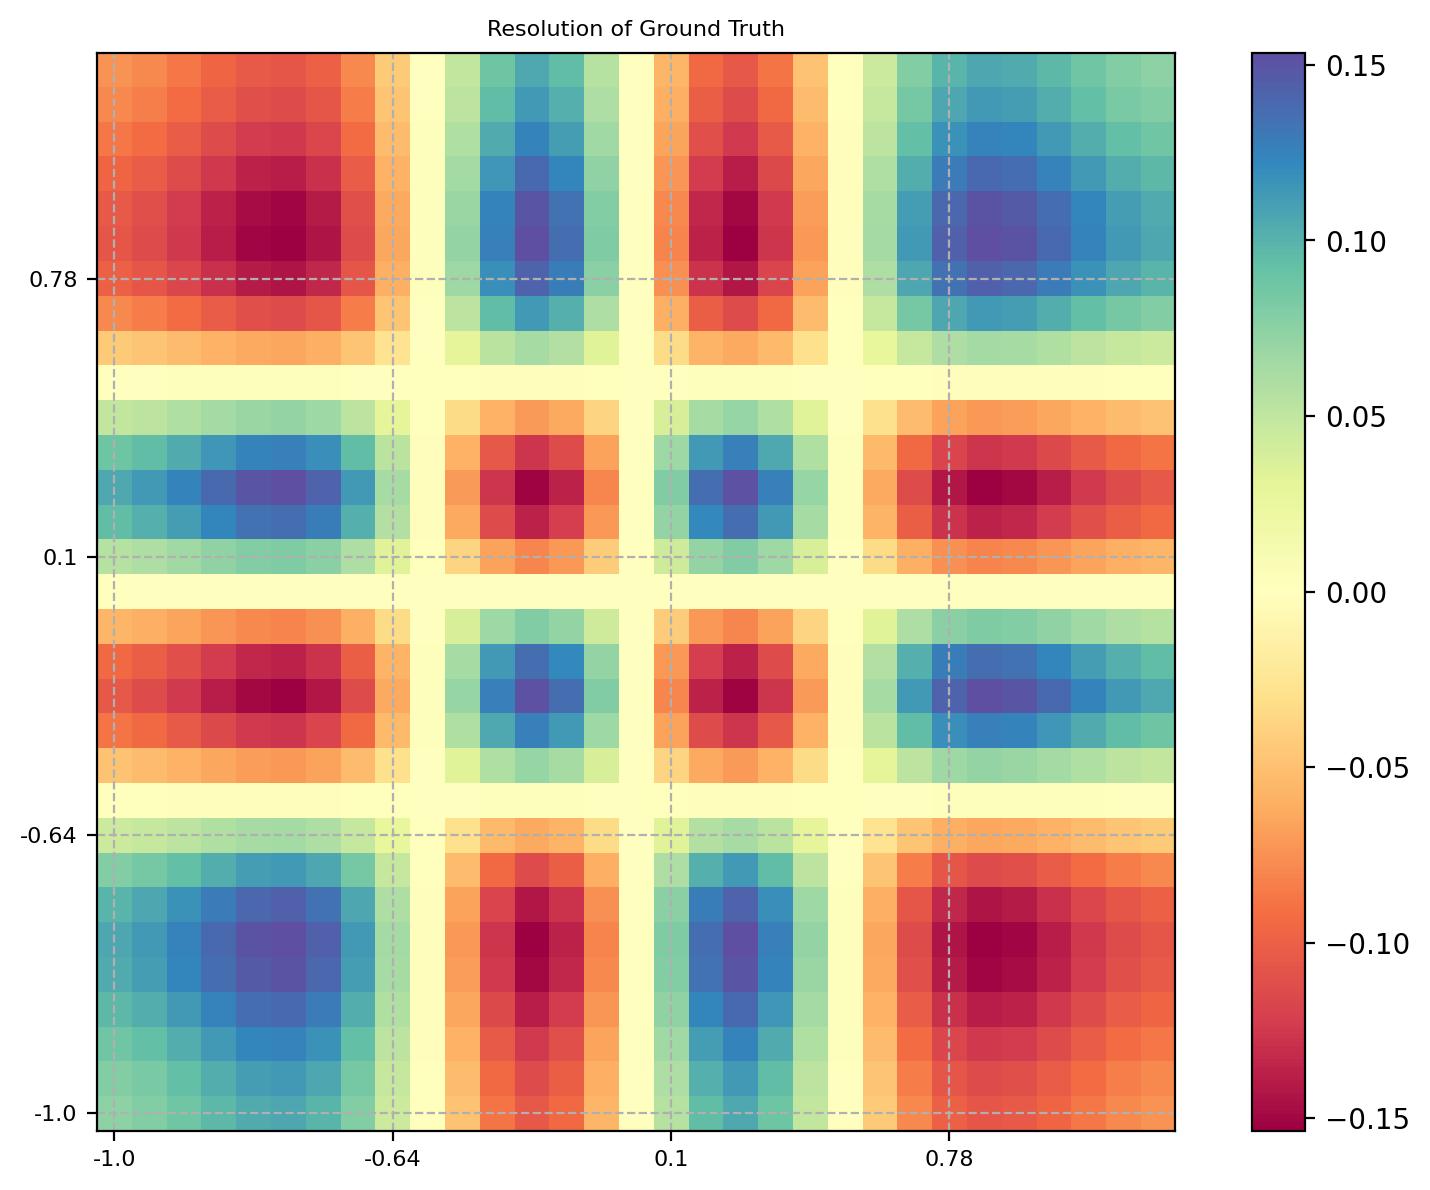

In [209]:
grid_plt = sob_2d.grid
xs_plt = sob_2d.axes
x_plt = grid_plt[:,0]
y_plt = grid_plt[:,1]
gt_plt = gt(x_plt, y_plt).reshape(len(xs_plt[1]),len(xs_plt[0]))
fn = None #"resolution_qho"

solver.plot2d(gt_plt, xs_plt[0], xs_plt[1], title="Resolution of Ground Truth", file_name=fn)

### Remark
You can either decide for the analytic solution or for the iterative solution.

### Gradient Flow :-: Analytic Solution AD-PSM

In [210]:
start = time.time()
KsK = 2*matmul(dmn.T, K.T, metric_2d(torch.mm(K, dmn)))\
        +2*matmul(bndr_0.T, metric_1d_0(bndr_0))\
        +2*matmul(bndr_1.T, metric_1d_1(bndr_1))

Ksf = 2*matmul(bndr_0.T, metric_1d_0(u_bndr_0))\
        +2*matmul(bndr_1.T, metric_1d_1(u_bndr_1))

w = matmul(KsK.inverse(), Ksf)
model.set_weights(w)
end = time.time()
print('time consumption: %.2fs' % (end-start))

time consumption: 0.02s


## AD-PSM Errors 

In [211]:
_, _ = solver.eval()
print(f'L1  Error: {solver.lp_err(1)}')
print(f'L2  Error: {solver.lp_err(2)}')
print(f'Max Error: {solver.lp_err(np.inf)}')

L1  Error: 1.3571949984498085e-12
L2  Error: 1.6686164208951758e-12
Max Error: 4.465983138857155e-12


### Plots

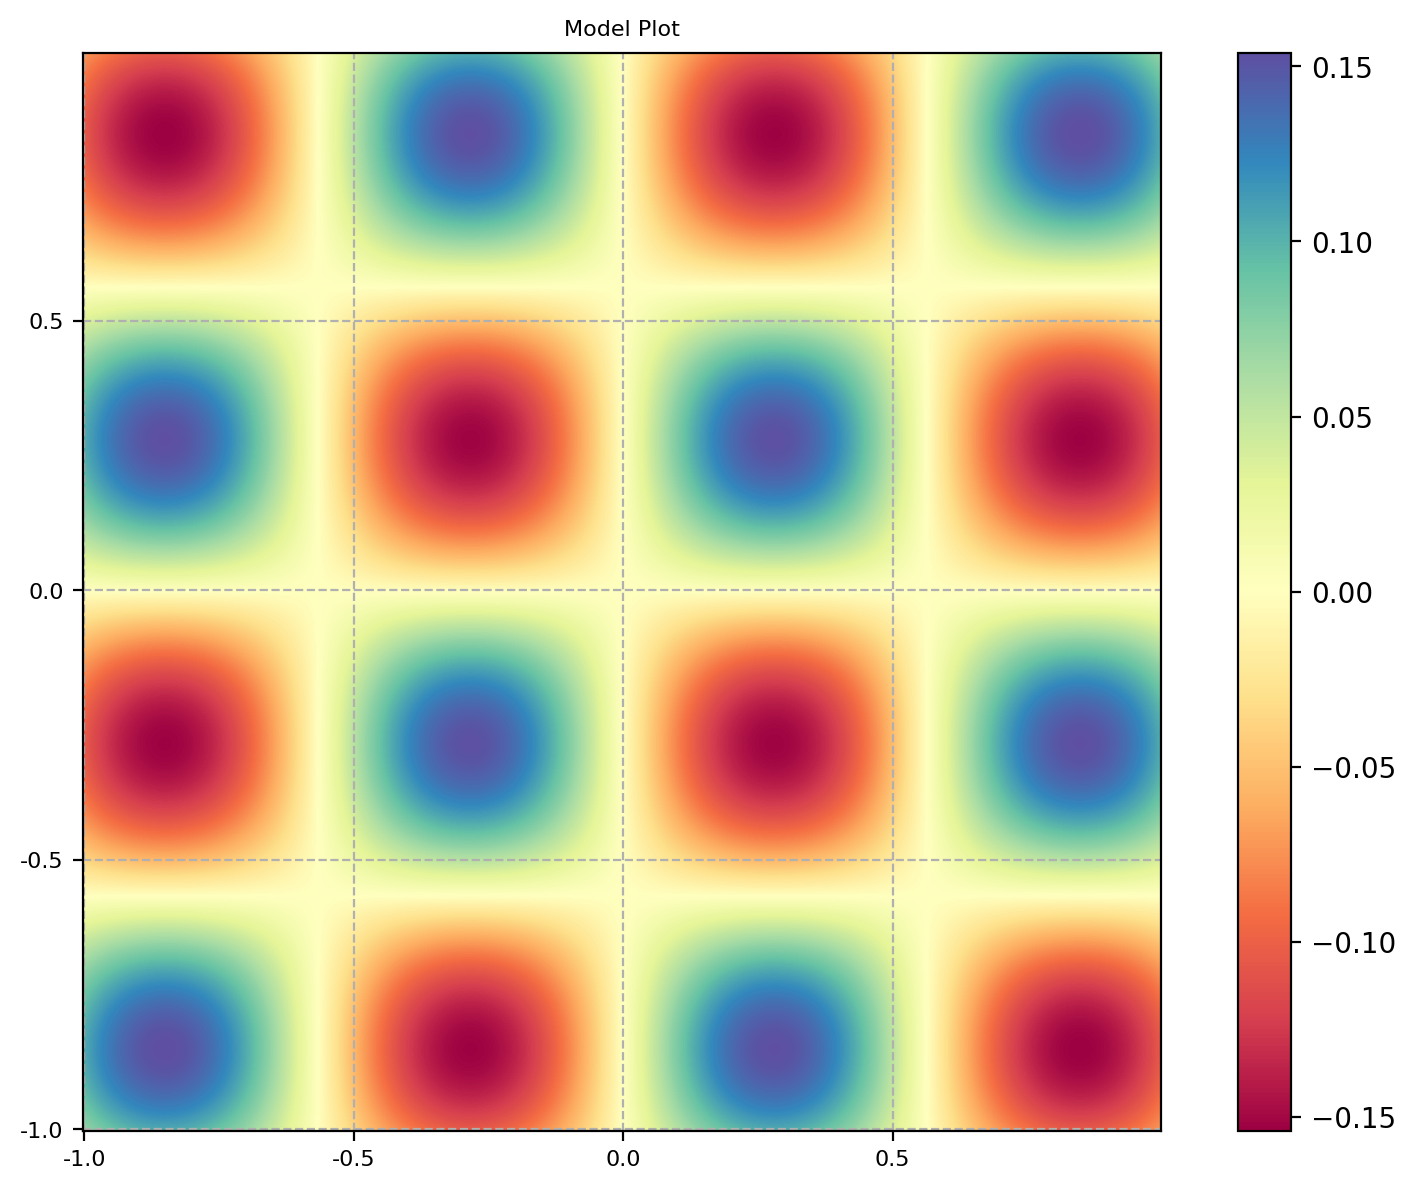

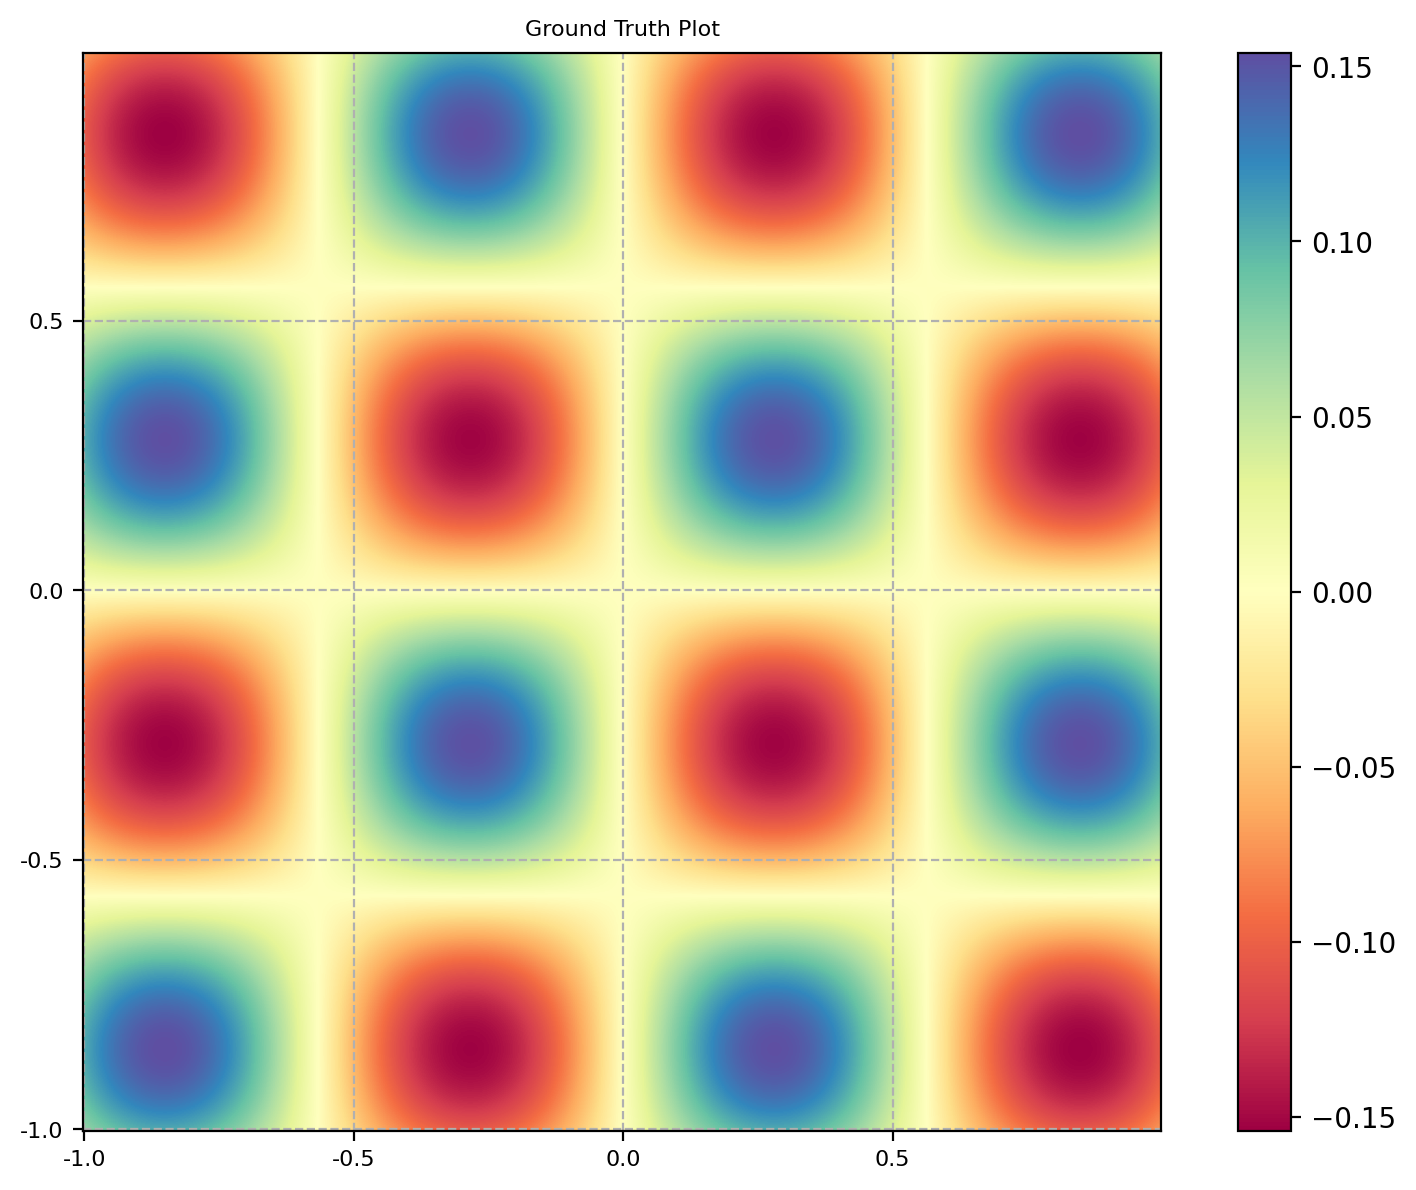

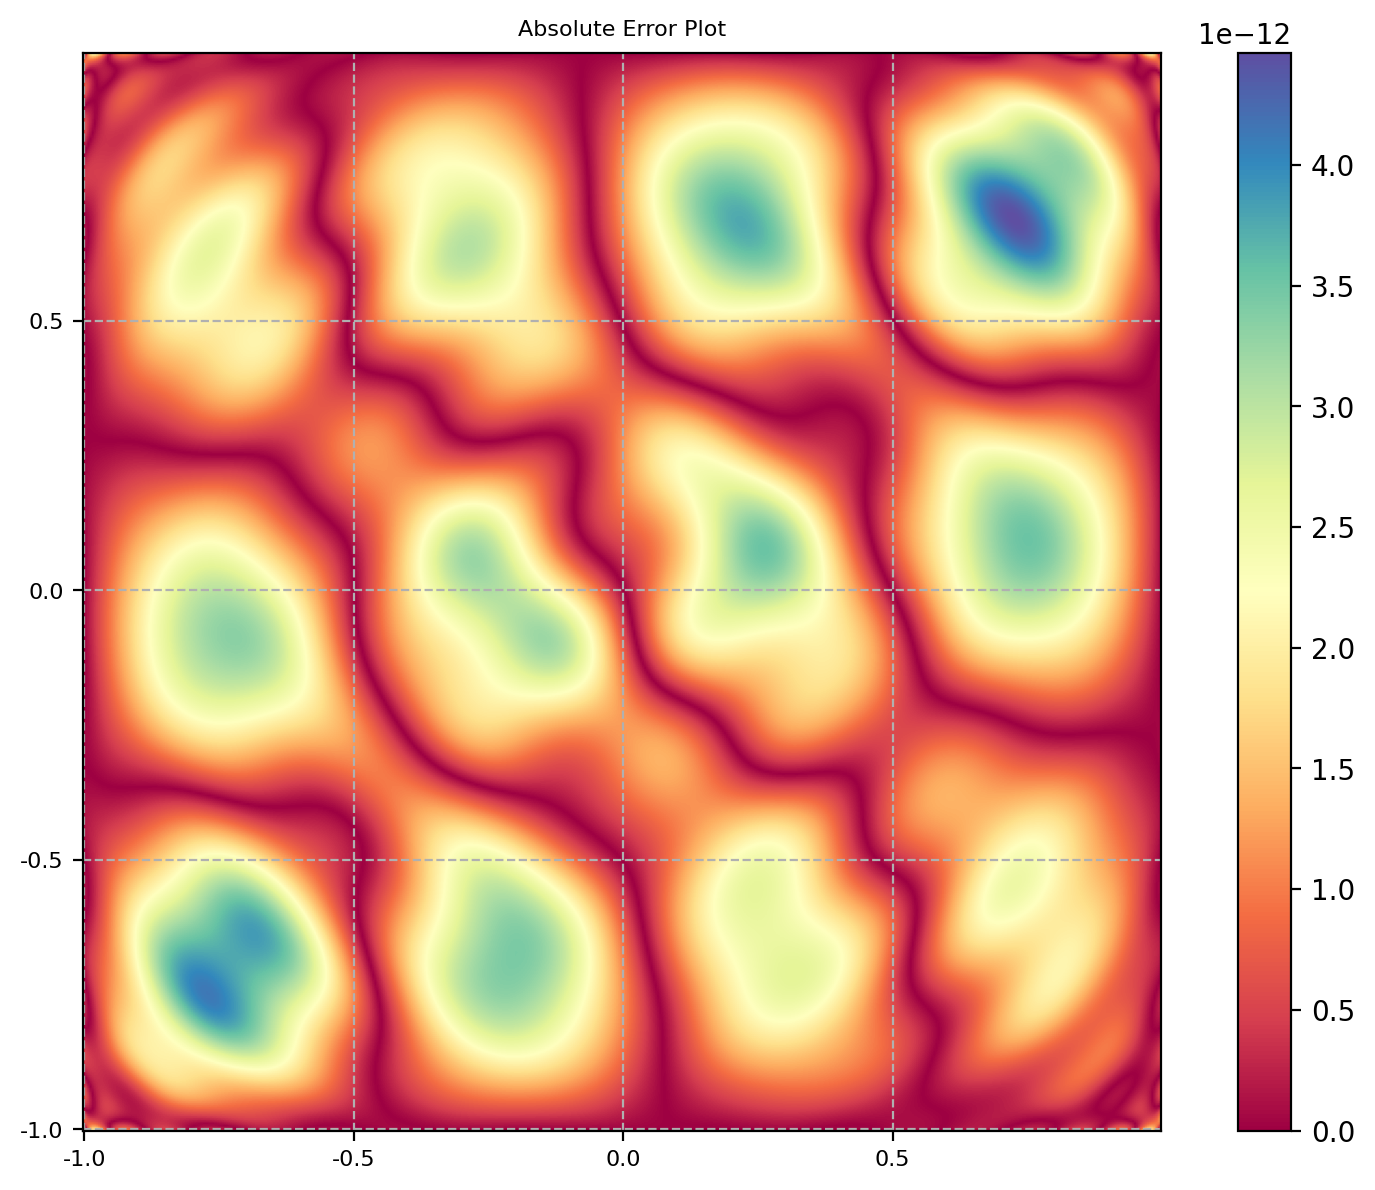

In [212]:
suffix = None #"qho"
solver.plot_model(suffix=suffix)
solver.plot_gt(suffix=suffix)
solver.plot_abs_err(suffix=suffix)
#solver.plot_losses(lower=0, upper=-1)